# Estimating the physiolgical cost of making _Mycobacterium tuberculosis_ proteins

I will adapt the approach outlined in the following paper to explore the cost of making _Mycobacterium tuberculosis_ proteins:

>Barton MD, Delneri D, Oliver SG, Rattray M, Bergman CM (2010) Evolutionary Systems Biology of Amino Acid Biosynthetic Cost in Yeast. PLoS ONE 5(8): e11935. doi:10.1371/journal.pone.0011935

The premise of this approach lays in the cost related to protein synthesis as driven by the diversion of cellular energy into amino acid biosynthesis. Barton _et al._ do an excellent job at introducing the topic in the intro to the paper.

In [1]:
#Set up kernel
import scipy as sp
from scipy import stats as ss
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from sklearn import utils as sku

mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['legend.numpoints'] = 1

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
import string as string
import requests as rq

%matplotlib inline
%cd ../data/Cost_data/

C:\Users\Andrej Trauner\Documents\STPH\Current\Cost_of_resistance\cost-of-resistance\data\Cost_data


Will import proteins of H37Rv in FASTA format from NCBI:

>ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF_000195955.2_ASM19595v2

And estimate the cost for each of them using the different metrics outlined in Barton's supplementary table 1.

One of the issues is that the genes are not annotated with Rvs but with RefSeq IDs. So I need to first parse the feature table available from RefSeq.

In [2]:
RefSeq_to_Rv = {}
for line in open('GCF_000195955.2_ASM19595v2_feature_table.txt'):
    split = line.strip().split()
    if split[0]=='CDS':
        RefSeq_to_Rv[split[9]] = split[-3]

MTBC_AA = {}
for line in open('GCF_000195955.2_ASM19595v2_protein.faa'):
    split = line.strip().split()
    if line[0]=='>':
        _refseq_id = split[0][1:] #to avoid >
        _id = RefSeq_to_Rv.get(_refseq_id, _refseq_id) #get the Rv from above
        MTBC_AA[_id]='' #empty string for the aa sequence
    if line[0]!='>':
        MTBC_AA[_id]+=split[0] 

In [3]:
cost_matrix = pd.read_csv('Barton_2010_supp_1.csv', index_col=0)
#NB I've modified the amino acid designations to single letters
cost_matrix.head()

,akashi,craig_energy,craig_steps,ecoli_car_abs,ecoli_car_rel,ecoli_nit_abs,ecoli_nit_rel,ecoli_sul_abs,ecoli_sul_rel,wagner_ferm,wagner_resp,weight,yeast_car_abs,yeast_car_rel,yeast_nit_abs,yeast_nit_rel,yeast_sul_abs,yeast_sul_rel
A,11.7,12.5,1,0.475,0.164,1,0.457,0,0.000,2,14.5,89.1,0.500,0.223,1,0.820,0,0.000
R,27.3,18.5,10,1.190,0.237,4,1.052,0,0.000,13,20.5,174.2,1.393,0.218,4,1.149,0,0.000
N,14.7,4.0,1,0.632,0.102,2,0.429,0,0.000,6,18.5,132.1,0.786,0.078,2,0.364,0,0.000
D,12.7,1.0,1,0.535,0.087,1,0.214,0,0.000,3,15.5,133.1,0.614,0.178,1,0.532,0,0.000
C,24.7,24.5,9,1.050,0.065,1,0.081,1,3.733,13,26.5,121.2,0.750,0.005,1,0.012,1,0.854


Next we need a function that will iterate through MTBC_AA with a given cost matrix.

In [4]:
def protein_cost(AA_seq, cost_dict):
    """Calculates the numerical cost value
    for a given AA sequence based on a cost
    matrix.
    
    INPUT:
    ------
    AA_seq: string, FASTA_AA
    cost_dict: dict, FASTA_AA:float(cost)
    
    OUTPUT:
    -------
    cost, float
    """
    
    _cost = 0
    for x in AA_seq:
        _cost+=float(cost_dict.get(x,0))
        
    return _cost

def proteome_cost(AA_dict, cost_matrix, approach='akashi'):
    """Calcualte the cost for a set of proteins
    given a matrix.
    
    INPUT:
    ------
    AA_dict: dict, protein:FASTA_AA
    cost_matrix: pd.DataFrame, e.g. cost_matrix from Barton et al
    approach: str, one of columns from the cost_matrix
    
    OUTPUT:
    -------
    dict, protein:cost
    """
    
    _cost_dict = {_x : cost_matrix[approach][_x] for _x in cost_matrix.index}
    
    _AA_cost = {_k : protein_cost(_v, _cost_dict) for (_k,_v) in AA_dict.items()}
    
    return _AA_cost

Let's take the functions for a spin.

In [5]:
MTBC_cost_akashi = proteome_cost(MTBC_AA, cost_matrix, approach='akashi')
MTBC_cost_cen = proteome_cost(MTBC_AA, cost_matrix, approach='craig_energy')
MTBC_cost_cst = proteome_cost(MTBC_AA, cost_matrix, approach='craig_steps')
MTBC_cost_wei = proteome_cost(MTBC_AA, cost_matrix, approach='weight')

Text(0.5, 0, 'MW cost')

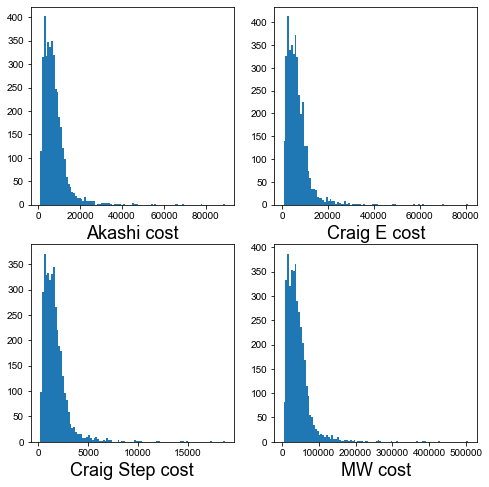

In [6]:
plt.figure('MTBC_akashi', figsize=(8,8))
plt.subplot(221)
plt.hist(list(MTBC_cost_akashi.values()), bins=100)
plt.xlabel('Akashi cost', size=18)
plt.subplot(222)
plt.hist(list(MTBC_cost_cen.values()), bins=100)
plt.xlabel('Craig E cost', size=18)
plt.subplot(223)
plt.hist(list(MTBC_cost_cst.values()), bins=100)
plt.xlabel('Craig Step cost', size=18)
plt.subplot(224)
plt.hist(list(MTBC_cost_wei.values()), bins=100)
plt.xlabel('MW cost', size=18)

These values look remarkably similar. Now let's apply them to the GENETIC DIVERSITY MTBC data, e.g. Label Free Quantitation (LFQ) data from SWATH-MS. I've normalised the data such that the overall number of proteins is the same.

In [7]:
def sample_cost(proteome, sample, cost_matrix):
    """Calculates the cost of a proteome
    given absolute quantiations of proteins
    
    INPUTS:
    -------
    proteome: DataFrame, aFLQ
    sample: str, column name of interes
    cost_matrix: dict, keys match DataFrame index
    
    OUTPUT:
    -------
    float, estimated cost
    """
    
    _cost = 0
    
    for _x in proteome.index:

        _cost+=proteome[sample][_x]*cost_matrix.get(_x,1) #returns factor of 1 if no cost is defined
    
    return _cost    

In [8]:
proteome = pd.read_csv('GENETIC_DIVERSITY_SUMMARY_PROTEOME.csv', index_col=0)

proteome['Akashi'] = [MTBC_cost_akashi.get(x,1) for x in proteome.index]
proteome['Craig_E'] = [MTBC_cost_cen.get(x,1) for x in proteome.index]
proteome['Craig_Step'] = [MTBC_cost_cst.get(x,1) for x in proteome.index]
proteome['MW'] = [MTBC_cost_wei.get(x,1) for x in proteome.index]

samples = ['L2_11S', 'L2_12S', 'L1_11S', 'L1_12S', 'L1_13S', 
           'L2_21S', 'L2_22S', 'L2_31S', 'L2_32S', 'L1_21S', 
           'L1_22S', 'L1_23S', 'L2_21R', 'L2_22R', 'L2_31R', 
           'L2_32R', 'L1_11R', 'L1_12R', 'L1_13R', 'L1_21R', 
           'L1_22R', 'L1_23R', 'L2_11R', 'L2_12R']

#add weight factor
proteome['WEIGHT'] = proteome[samples].mean(1)/1e6

In [9]:
proteome.head()

,L2_11S,L2_12S,L1_11S,L1_12S,L1_13S,L2_21S,L2_22S,L2_31S,L2_32S,L1_21S,...,LFC_145,LFC_155,SIG_155,SIG_157,LFC_157,Akashi,Craig_E,Craig_Step,MW,WEIGHT
Rv0001,91726.43650,104269.96460,104587.61110,101400.51380,105807.16150,93553.03148,90699.05515,117968.489800,116282.659600,107134.60200,...,-0.000410,-0.144340,0,0,-0.075564,11399.7,9333.5,2508.0,65685.5,0.090501
Rv0002,729036.68430,636818.16980,814002.63930,823665.77120,886021.00660,616823.73080,653313.28650,707246.657700,617489.078300,759740.33630,...,0.161285,0.172852,0,1,0.488515,8496.1,7497.0,1910.0,49340.6,0.743532
Rv0003,45227.75869,42149.15228,53654.37829,48330.93259,46646.28110,44919.14043,42931.38042,41165.276240,44775.060870,48752.31029,...,0.153545,0.296491,1,1,0.737557,8461.6,7480.5,1883.0,49134.3,0.051033
Rv0004,15091.53178,17752.71909,14813.42029,12892.84507,10947.05983,18026.34065,16356.30349,9134.161827,9469.486994,15969.72931,...,-0.456547,0.416248,0,1,0.430350,3956.0,3317.5,925.0,23286.4,0.012899
Rv0005,283366.86420,289545.57330,347274.83210,356793.97460,333147.14340,304987.63770,309667.99770,273912.652200,263862.344300,408204.28070,...,-0.035864,-0.201390,1,0,-0.070551,15163.4,12698.0,3326.0,86239.6,0.306265


Next, let's calculate the cost of the proteome per sample.

In [10]:
PER_PROTEIN_COST = {}
for x in samples:
    PER_PROTEIN_COST[x] = {'Akashi': sum(proteome[x]*proteome.Akashi),
                          'Craig_E': sum(proteome[x]*proteome.Craig_E),
                          'Craig_Step': sum(proteome[x]*proteome.Craig_Step),
                          'MW': sum(proteome[x]*proteome.MW)}
PER_PROTEIN_COST_df = pd.DataFrame(PER_PROTEIN_COST).T
PER_PROTEIN_COST_df

,Akashi,Craig_E,Craig_Step,MW
L2_11S,4.068544e+12,3.479248e+12,8.901409e+11,2.330088e+13
L2_12S,4.077727e+12,3.487495e+12,8.921834e+11,2.335513e+13
L1_11S,4.000592e+12,3.422030e+12,8.752515e+11,2.291056e+13
L1_12S,4.051732e+12,3.467457e+12,8.861997e+11,2.319647e+13
L1_13S,4.016178e+12,3.436177e+12,8.786192e+11,2.299998e+13
L2_21S,4.053985e+12,3.468135e+12,8.874814e+11,2.320737e+13
L2_22S,4.083499e+12,3.494708e+12,8.937596e+11,2.337182e+13
L2_31S,4.050868e+12,3.466619e+12,8.865178e+11,2.319024e+13
L2_32S,4.048641e+12,3.463856e+12,8.860761e+11,2.318708e+13
L1_21S,4.081005e+12,3.488315e+12,8.934283e+11,2.338611e+13


Add labels to distinguish between lineage 1 and lineage 2 [L] and wild type vs RpoB mutant [INT].

In [11]:
PER_PROTEIN_COST_df['INT'] = [int('R' in x) for x in PER_PROTEIN_COST_df.index]
PER_PROTEIN_COST_df['L'] = [int('L2' in x)+1 for x in PER_PROTEIN_COST_df.index]

Check whether the cost of the proteome differs between wt and RpoB using different metrics of cost.

In [12]:
ss.mannwhitneyu(PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==1], 
                PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==0])

MannwhitneyuResult(statistic=14.0, pvalue=0.00045046779818000833)

In [13]:
ss.mannwhitneyu(PER_PROTEIN_COST_df.Craig_E[PER_PROTEIN_COST_df.INT==1], 
                PER_PROTEIN_COST_df.Craig_E[PER_PROTEIN_COST_df.INT==0])

MannwhitneyuResult(statistic=10.0, pvalue=0.00019210101351748536)

In [14]:
ss.mannwhitneyu(PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==1], 
                PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==0])

MannwhitneyuResult(statistic=17.0, pvalue=0.0008260197281170818)

In all three cases the cost seems to be significantly different.

Let's produce boxplots for the cost of RpoB [INT=1] in Lineage 1 [L=1] and 2 [L=2].

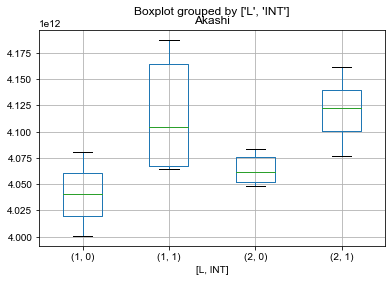

In [15]:
PER_PROTEIN_COST_df.boxplot('Akashi', by=['L','INT'])

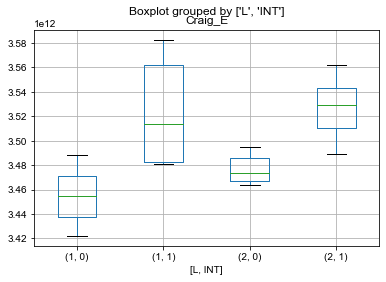

In [16]:
PER_PROTEIN_COST_df.boxplot('Craig_E', by=['L','INT'])

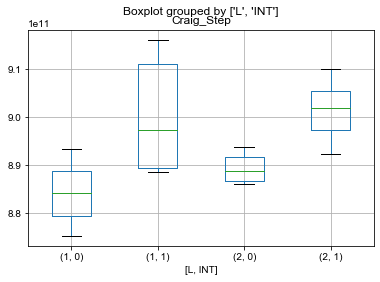

In [17]:
PER_PROTEIN_COST_df.boxplot('Craig_Step', by=['L','INT'])

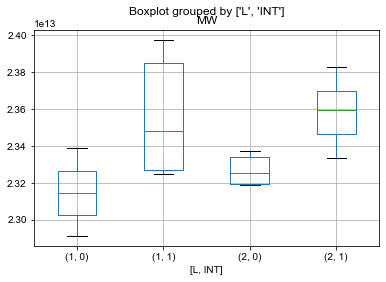

In [18]:
PER_PROTEIN_COST_df.boxplot('MW', by=['L','INT'])

All four approaches give the same output, lineage 1 has a higher increase in cost of RpoB. However, regardless of Lineage RpoB proteome seems more resource intese than the wild type. Let's plot this without Lineage-driven segregation.

Also, for the sake of simplicity I will use only MW and Akashi [ATP equivalents] from now on.

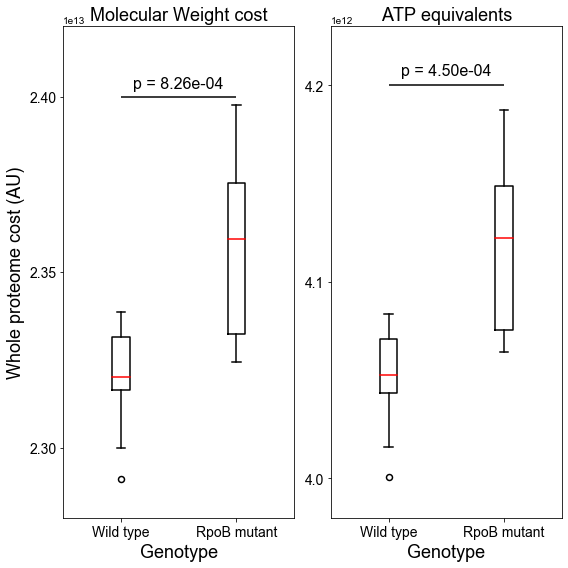

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.boxplot([PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==0], 
             PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==1]],
            boxprops={'linewidth':1.5}, whiskerprops={'linewidth':1.5},
            capprops={'linewidth':1.5},medianprops={'linewidth':1.5, 'color':'red'},
            flierprops={'mew':1.5})
plt.xticks([1,2],['Wild type','RpoB mutant'], size=14)
plt.xlabel('Genotype', size=18)
plt.title('Molecular Weight cost', size=18)
plt.yticks([2.30e13, 2.35e13, 2.40e13],size=14)
plt.ylim(2.28e13, 2.42e13)
plt.hlines(2.40e13,1,2)
plt.text(1.5,
         2.4025e13,
         'p = {0:0=.2e}'.format(ss.mannwhitneyu(PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==1], 
                                                PER_PROTEIN_COST_df.MW[PER_PROTEIN_COST_df.INT==0])[1]), 
         horizontalalignment='center',
         size=16)
plt.ylabel('Whole proteome cost (AU)', size=18)

plt.subplot(122)
plt.boxplot([PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==0], 
             PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==1]],
            boxprops={'linewidth':1.5}, whiskerprops={'linewidth':1.5},
            capprops={'linewidth':1.5},medianprops={'linewidth':1.5, 'color':'red'}, 
            flierprops={'mew':1.5})
plt.xticks([1,2],['Wild type','RpoB mutant'], size=14)
plt.xlabel('Genotype', size=18)
plt.title('ATP equivalents', size=18)
plt.yticks([4e12, 4.1e12, 4.2e12],size=14)
plt.ylim(3.98e12, 4.23e12)
plt.hlines(4.2e12,1,2)
plt.text(1.5,
         4.205e12,
         'p = {0:0=.2e}'.format(ss.mannwhitneyu(PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==1], 
                                                PER_PROTEIN_COST_df.Akashi[PER_PROTEIN_COST_df.INT==0])[1]), 
         horizontalalignment='center',
         size=16)

plt.tight_layout()

# plt.savefig('../cost-of-resistance/reports/figures/2_Protein_cost_distribution.pdf')
# plt.savefig('../cost-of-resistance/reports/figures/2_Protein_cost_distribution.png', dpi=600)

OK, there seems to be something here... as a reality check, see if the same can be said using the log-fold changes [lfc] determined by MSstat...

In [20]:
print(sum((np.array(proteome.LFC1[(proteome.SIG1==1)], dtype=float)**2)*np.array(proteome.Akashi[(proteome.SIG1==1)], dtype=float)))
print(sum((np.array(proteome.LFC2[(proteome.SIG2==1)], dtype=float)**2)*np.array(proteome.Akashi[(proteome.SIG2==1)], dtype=float)))

2368121.1203124477
212878.2282162161


Looks like the lfc data support this. Let's do a final check and run a logistic regression on these two metrics.

In [21]:
model = smf.logit('INT ~ Akashi', PER_PROTEIN_COST_df)
result = model.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.344577
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    INT   No. Observations:                   24
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            0
Date:                Sun, 13 Jun 2021   Pseudo R-squ.:                  0.5029
Time:                        00:12:44   Log-Likelihood:                -8.2698
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -320.8248    159.380     -2.013      0.044    -633.204      -8.446
Akashi      7.869e-11   3.91e

In [22]:
model = smf.logit('INT ~ MW', PER_PROTEIN_COST_df)
result = model.fit()
print (result.summary())

Optimization terminated successfully.
         Current function value: 0.383124
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    INT   No. Observations:                   24
Model:                          Logit   Df Residuals:                       23
Method:                           MLE   Df Model:                            0
Date:                Sun, 13 Jun 2021   Pseudo R-squ.:                  0.4473
Time:                        00:12:44   Log-Likelihood:                -9.1950
converged:                       True   LL-Null:                       -16.636
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -260.6410    121.517     -2.145      0.032    -498.810     -22.472
MW          1.116e-11   5.21e

The results check out. OK, now, let's correlate DE perturbation costs with growth rate fitness estimation.

First illustrate the relationship between generation time [wt vs cognate RpoB] and relative fitness of the mutatnt [wt growth rate vs cost of RpoB].

In [23]:
GC_df = pd.read_csv('./RpoB_GC_fitness.csv', index_col=0)

Text(0, 0.5, '$rpoB$ relative fitness')

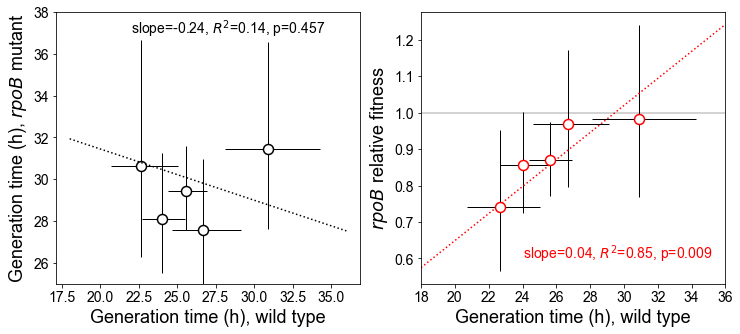

In [24]:
TbX011_strains = ['N0052', 'N0072', 'N0145', 'N0155', 'N0157']

plt.figure('WTvsMut', figsize=(12,5))
plt.subplot(121)
for ind in TbX011_strains:
    plt.plot(GC_df.GEN_TIME[ind], GC_df.GEN_TIME_MUT[ind], 'o', mec='black', mfc='white', mew=1.5, ms=10)
    plt.hlines(GC_df.GEN_TIME_MUT[ind], GC_df.CONF_WT_L[ind], GC_df.CONF_WT_H[ind], lw=1)
    plt.vlines(GC_df.GEN_TIME[ind], GC_df.CONF_MUT_L[ind], GC_df.CONF_MUT_H[ind], lw=1)
s,i,r,p,e = ss.linregress(GC_df.GEN_TIME, GC_df.GEN_TIME_MUT)
plt.plot(np.arange(18,37,1), s*np.arange(18,37,1)+i, 'k:')
plt.text(22,37,r'slope=%.2f, $R^2$=%.2f, p=%.3f' %(s,r**2,p), size=14)

plt.yticks(size=14)
plt.xticks(size=14)
plt.xlabel('Generation time (h), wild type', size=18)
plt.ylabel(r'Generation time (h), $rpoB$ mutant', size=18)
plt.ylim(25,38)


plt.subplot(122)
s,i,r,p,e = ss.linregress(GC_df.GEN_TIME, GC_df.RPOB_COST)
plt.plot(np.arange(18,37,1), s*np.arange(18,37,1)+i, 'r:')
plt.hlines(1,17,37,colors='lightgray', lw=2)
for ind in TbX011_strains:
    plt.plot(GC_df.GEN_TIME[ind], GC_df.RPOB_COST[ind], 'wo', mec='red', mew=1.5, ms=10)
    plt.hlines(GC_df.RPOB_COST[ind], GC_df.CONF_WT_L[ind], GC_df.CONF_WT_H[ind], lw=1)
    plt.vlines(GC_df.GEN_TIME[ind], 
               GC_df.CONF_WT_L[ind]/GC_df.CONF_MUT_H[ind], 
               GC_df.CONF_WT_H[ind]/GC_df.CONF_MUT_L[ind], lw=1)
plt.text(24,.6,r'slope=%.2f, $R^2$=%.2f, p=%.3f' %(s,r**2,p), color='red', size=14)
plt.yticks(size=14)
plt.xticks(size=14)
plt.xlim(18,36)
plt.xlabel('Generation time (h), wild type', size=18)
plt.ylabel(r'$rpoB$ relative fitness', size=18)
#plt.savefig('../160418_TbX011_analysis/Figures/160523_RpoB_cost.pdf')

The general trend seems to be that the faster the parent grows, the bigger the impact of the mutation.

Based on the fact that it seems that RpoB mutants have a larger investment in the proteome, let's check if the investment in the proteome correlates with relative fitness. And then we can build on this to look whether expression perturbation plays a role as well.

Start by calculating broad confidence intervals for the cost estimates [already plotted above].

In [25]:
GC_df['rpoB_CI_L'] = GC_df.CONF_WT_L[GC_df.index]/GC_df.CONF_MUT_H[GC_df.index]
GC_df['rpoB_CI_H'] = GC_df.CONF_WT_H[GC_df.index]/GC_df.CONF_MUT_L[GC_df.index]

In [26]:
GC_df

,CONF_MUT_H,CONF_MUT_L,CONF_WT_H,CONF_WT_L,GEN_TIME,GEN_TIME_MUT,RPOB_COST,rpoB_CI_L,rpoB_CI_H
N0052,25.500163,31.268171,22.683285,25.525747,24.020718,28.091134,0.855100,1.001003,0.725443
N0072,27.588163,31.598325,24.409496,26.903762,25.596008,29.457390,0.868916,0.975192,0.772493
N0145,24.834321,30.976940,24.629563,29.120745,26.687520,27.567600,0.968076,1.172601,0.795093
N0155,27.612933,36.574391,28.129836,34.265549,30.896012,31.468089,0.981820,1.240924,0.769113
N0155_TbX008,30.404542,39.183716,18.426720,21.151434,19.695287,34.240344,0.575207,0.695667,0.470265
N0157,26.280665,36.684579,20.694956,25.016986,22.651649,30.623089,0.739692,0.951916,0.564132


Calculate the cost of the difference between the proteomes for Akashi and MW. The 95% confidence interval for the calculation is derived empirically from a 1000x bootstrap.

In [27]:
strain_costs_ALL = {}
#rpoB higher positive log
for (lfc, sig, strain) in zip(['LFC_52', 'LFC_72', 'LFC_145', 'LFC_155', 'LFC_157'],
                              ['SIG_52', 'SIG_72', 'SIG_145', 'SIG_155', 'SIG_157'], 
                              ['N0052', 'N0072', 'N0145', 'N0155', 'N0157']):
    A_C = []
    A_CM = []
    for N in range(1000):
        rsmpl = sku.resample(proteome)
        _cost = (2**np.abs(rsmpl[lfc], dtype=float))*np.array(rsmpl.Akashi, dtype=float)
        _cost[np.where(rsmpl[lfc]<=0)[0]]*=-1
        _cost*=np.array(rsmpl.WEIGHT,dtype=float)
        A_C.append(sum(_cost))
        _cost = (2**np.abs(rsmpl[lfc], dtype=float))*np.array(rsmpl.MW, dtype=float)
        _cost[np.where(rsmpl[lfc]<=0)[0]]*=-1
        _cost*=np.array(rsmpl.WEIGHT,dtype=float)
        A_CM.append(sum(_cost))

    A_C = sorted(A_C)
    A_CM = sorted(A_CM)

    strain_costs_ALL[strain] = {'Akashi_cost': A_C[499], 'Akashi_CI_L': A_C[25], 'Akashi_CI_H': A_C[-25],
                            'MW_cost': A_CM[499], 'MW_CI_L': A_CM[25], 'MW_CI_H': A_CM[-25]}
    print(strain)
    print(A_C[499], A_C[25], A_C[-25])
    print(A_CM[499], A_CM[25], A_CM[-25])

N0052
2458222.363803859 1815245.9577667662 3267685.195888331
14133671.476942012 10352600.445829894 18931287.12781876
N0072
1989029.46445843 1334741.2994654828 2816908.9180590888
11303053.722605944 7534658.478773438 16100806.519567113
N0145
226569.44811840146 -488310.26828207914 847548.3700016782
1203765.450862545 -2980749.1762355366 4826299.19303008
N0155
1689214.0791355683 1078065.3587622386 2408688.70898051
9692284.844562197 6168471.748528662 13857358.89771309
N0157
2693409.226106007 1971133.3791120262 3704390.7492818744
15407145.460725393 11256024.922703976 21251939.17892965


Collate the data.

In [28]:
ALL_df = pd.DataFrame(strain_costs_ALL, index=strain_costs_ALL[list(strain_costs_ALL.keys())[0]].keys(), dtype=float).T

In [29]:
ALL_df

,Akashi_cost,Akashi_CI_L,Akashi_CI_H,MW_cost,MW_CI_L,MW_CI_H
N0052,2.458222e+06,1.815246e+06,3.267685e+06,1.413367e+07,1.035260e+07,1.893129e+07
N0072,1.989029e+06,1.334741e+06,2.816909e+06,1.130305e+07,7.534658e+06,1.610081e+07
N0145,2.265694e+05,-4.883103e+05,8.475484e+05,1.203765e+06,-2.980749e+06,4.826299e+06
N0155,1.689214e+06,1.078065e+06,2.408689e+06,9.692285e+06,6.168472e+06,1.385736e+07
N0157,2.693409e+06,1.971133e+06,3.704391e+06,1.540715e+07,1.125602e+07,2.125194e+07


Plot the two investement metrics against relative fitness.

Text(0.2, 0.45, 'Slope=-0.14, $R^2$=0.59, p=0.13')

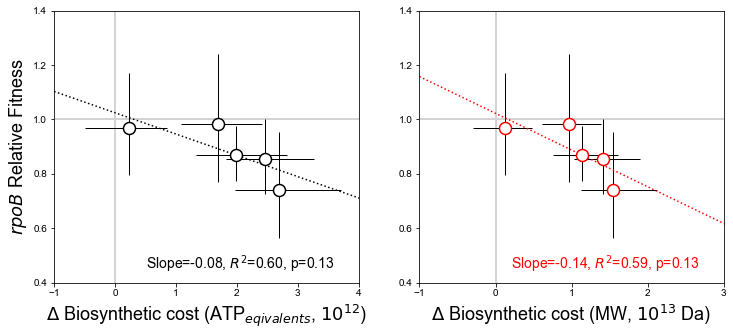

In [30]:
plt.figure('Cost_Fitness_all', figsize=(12,5))

plt.subplot(121)
rpc = [float(GC_df.RPOB_COST[x]) for x in ALL_df.index]
pbc = [float(ALL_df.Akashi_cost[x])*1e-6 for x in ALL_df.index]
s,i,r,p,e = ss.linregress(pbc, rpc)
sp_r, sp_p = ss.spearmanr(pbc, rpc)
plt.plot([-1,5], s*np.array([-1,5])+i,'k:')
plt.hlines(1,-1,4,colors='lightgray', lw=2)
plt.vlines(0,.4,1.4,colors='lightgray', lw=2)
for x in ALL_df.index:
    plt.plot(ALL_df.Akashi_cost[x]*1e-6, GC_df.RPOB_COST[x], 'o', mec='black', mew=1.5, mfc='white', ms=12)
    plt.hlines(GC_df.RPOB_COST[x], ALL_df.Akashi_CI_L[x]*1e-6, ALL_df.Akashi_CI_H[x]*1e-6, lw=1)
    plt.vlines(ALL_df.Akashi_cost[x]*1e-6, 
               GC_df.CONF_WT_L[x]/GC_df.CONF_MUT_H[x], 
               GC_df.CONF_WT_H[x]/GC_df.CONF_MUT_L[x], lw=1)
plt.xlim(-1,4)
plt.ylim(.4,1.4)
plt.ylabel(r'$rpoB$ Relative Fitness', size=18)
plt.xlabel(r'$\Delta$ Biosynthetic cost (ATP$_{eqivalents}$, $10^{12}$)', size=18)
plt.text(0.5,0.45,r'Slope=%.2f, $R^2$=%.2f, p=%.2f' %(s,r**2,p), size=14)
#plt.text(1.5,0.45,r'$\rho_s$ = %.2f, p = %.2f' %(sp_r,sp_p), size=16)


plt.subplot(122)
rpc = [float(GC_df.RPOB_COST[x]) for x in ALL_df.index]
pbc = [float(ALL_df.MW_cost[x])*1e-7 for x in ALL_df.index]
s,i,r,p,e = ss.linregress(pbc, rpc)
sp_r, sp_p = ss.spearmanr(pbc, rpc)
plt.plot([-1,5], s*np.array([-1,5])+i,'r:')
plt.hlines(1,-1,3,colors='lightgray', lw=2)
plt.vlines(0,.4,1.4,colors='lightgray', lw=2)
for x in ALL_df.index:
    plt.plot(ALL_df.MW_cost[x]*1e-7, GC_df.RPOB_COST[x], 'o', mec='red', mew=1.5, mfc='white', ms=12)
    plt.hlines(GC_df.RPOB_COST[x], ALL_df.MW_CI_L[x]*1e-7, ALL_df.MW_CI_H[x]*1e-7, lw=1)
    plt.vlines(ALL_df.MW_cost[x]*1e-7, 
               GC_df.CONF_WT_L[x]/GC_df.CONF_MUT_H[x], 
               GC_df.CONF_WT_H[x]/GC_df.CONF_MUT_L[x], lw=1)
plt.xlim(-1,3)
plt.xticks(range(-1,4))
plt.ylim(.4,1.4)
plt.xlabel(r'$\Delta$ Biosynthetic cost (MW, $10^{13}$ Da)', size=18)
plt.text(0.2,0.45,r'Slope=%.2f, $R^2$=%.2f, p=%.2f' %(s,r**2,p),color='red', size=14)
#plt.text(1,0.45,r'$\rho_s$ = %.2f, p = %.2f' %(sp_r,sp_p),color='red', size=16)
#plt.savefig('../160418_TbX011_analysis/Figures/160523_RpoB_DE_cost_lin.pdf')

Re-plot the above graph with Spearman correlations.

Text(1, 0.45, '$\\rho_s$ = -0.90, p = 0.04')

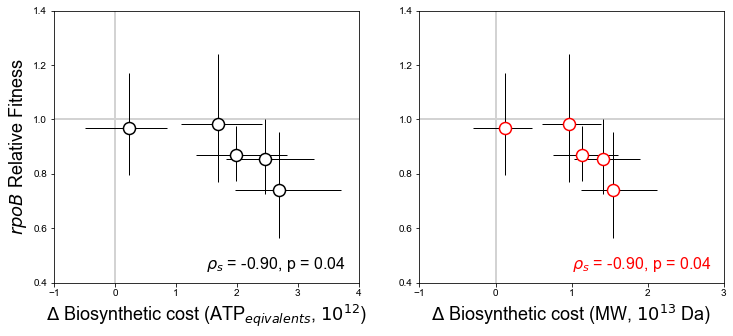

In [31]:
plt.figure('Cost_Fitness_all_spr', figsize=(12,5))

plt.subplot(121)
rpc = [float(GC_df.RPOB_COST[x]) for x in ALL_df.index]
pbc = [float(ALL_df.Akashi_cost[x])*1e-6 for x in ALL_df.index]
s,i,r,p,e = ss.linregress(pbc, rpc)
sp_r, sp_p = ss.spearmanr(pbc, rpc)
#plt.plot([-1,5], s*np.array([-1,5])+i,'k:')
plt.hlines(1,-1,4,colors='lightgray', lw=2)
plt.vlines(0,.4,1.4,colors='lightgray', lw=2)
for x in ALL_df.index:
    plt.plot(ALL_df.Akashi_cost[x]*1e-6, GC_df.RPOB_COST[x], 'o', mec='black', mew=1.5, mfc='white', ms=12)
    plt.hlines(GC_df.RPOB_COST[x], ALL_df.Akashi_CI_L[x]*1e-6, ALL_df.Akashi_CI_H[x]*1e-6, lw=1)
    plt.vlines(ALL_df.Akashi_cost[x]*1e-6, 
               GC_df.CONF_WT_L[x]/GC_df.CONF_MUT_H[x], 
               GC_df.CONF_WT_H[x]/GC_df.CONF_MUT_L[x], lw=1)
plt.xlim(-1,4)
plt.ylim(.4,1.4)
plt.ylabel(r'$rpoB$ Relative Fitness', size=18)
plt.xlabel(r'$\Delta$ Biosynthetic cost (ATP$_{eqivalents}$, $10^{12}$)', size=18)
#plt.text(0.5,0.45,r'Slope=%.2f, $R^2$=%.2f, p=%.2f' %(s,r**2,p), size=14)
plt.text(1.5,0.45,r'$\rho_s$ = %.2f, p = %.2f' %(sp_r,sp_p), size=16)


plt.subplot(122)
rpc = [float(GC_df.RPOB_COST[x]) for x in ALL_df.index]
pbc = [float(ALL_df.MW_cost[x])*1e-7 for x in ALL_df.index]
s,i,r,p,e = ss.linregress(pbc, rpc)
sp_r, sp_p = ss.spearmanr(pbc, rpc)
#plt.plot([-1,5], s*np.array([-1,5])+i,'r:')
plt.hlines(1,-1,3,colors='lightgray', lw=2)
plt.vlines(0,.4,1.4,colors='lightgray', lw=2)
for x in ALL_df.index:
    plt.plot(ALL_df.MW_cost[x]*1e-7, GC_df.RPOB_COST[x], 'o', mec='red', mew=1.5, mfc='white', ms=12)
    plt.hlines(GC_df.RPOB_COST[x], ALL_df.MW_CI_L[x]*1e-7, ALL_df.MW_CI_H[x]*1e-7, lw=1)
    plt.vlines(ALL_df.MW_cost[x]*1e-7, 
               GC_df.CONF_WT_L[x]/GC_df.CONF_MUT_H[x], 
               GC_df.CONF_WT_H[x]/GC_df.CONF_MUT_L[x], lw=1)
plt.xlim(-1,3)
plt.xticks(range(-1,4))
plt.ylim(.4,1.4)
plt.xlabel(r'$\Delta$ Biosynthetic cost (MW, $10^{13}$ Da)', size=18)
#plt.text(0.2,0.45,r'Slope=%.2f, $R^2$=%.2f, p=%.2f' %(s,r**2,p),color='red', size=14)
plt.text(1,0.45,r'$\rho_s$ = %.2f, p = %.2f' %(sp_r,sp_p),color='red', size=16)
#plt.savefig('../160418_TbX011_analysis/Figures/160523_RpoB_DE_cost_spr.pdf')

The graphs suggest a correlation between the relative fitness of *rpoB* mutants and the cost of their proteome. Importantly the Spearman rho  shows a stronger correlation than the Pearson. So we're not looking at a linear relationship, but we are definitely looking at a monotonically decreasing one. 

This is an interesting observation, however it's confirmation would require much more work to elaborate on the result. It is consistent with the literature.

## More general cost estimation

Add fitness data to the `ALL_df` dataframe.

In [32]:
ALL_df['RPOB_COST'] = GC_df.RPOB_COST[ALL_df.index]
ALL_df['RPOB_LOW'] = GC_df.rpoB_CI_L[ALL_df.index]
ALL_df['RPOB_HIGH'] = GC_df.rpoB_CI_H[ALL_df.index]

ALL_df


,Akashi_cost,Akashi_CI_L,Akashi_CI_H,MW_cost,MW_CI_L,MW_CI_H,RPOB_COST,RPOB_LOW,RPOB_HIGH
N0052,2.458222e+06,1.815246e+06,3.267685e+06,1.413367e+07,1.035260e+07,1.893129e+07,0.855100,1.001003,0.725443
N0072,1.989029e+06,1.334741e+06,2.816909e+06,1.130305e+07,7.534658e+06,1.610081e+07,0.868916,0.975192,0.772493
N0145,2.265694e+05,-4.883103e+05,8.475484e+05,1.203765e+06,-2.980749e+06,4.826299e+06,0.968076,1.172601,0.795093
N0155,1.689214e+06,1.078065e+06,2.408689e+06,9.692285e+06,6.168472e+06,1.385736e+07,0.981820,1.240924,0.769113
N0157,2.693409e+06,1.971133e+06,3.704391e+06,1.540715e+07,1.125602e+07,2.125194e+07,0.739692,0.951916,0.564132


Next, let's take the euclidean distance between the expression levels of each gene in RpoB mutant - wild type pairs for each strain background for the proteomic and transcriptomic data. I will use this as the metric of similarity between expression profiles.

In [33]:
strain_pairs = [
    (['L2_11S','L2_12S'],['L2_11R','L2_12R']),
    (['L1_11S','L1_12S','L1_13S'],['L1_11R','L1_12R','L1_13R']),
    (['L2_21S','L2_22S'],['L2_21R','L2_22R']),
    (['L2_31S','L2_32S'],['L2_31R','L2_32R']),
    (['L1_21S','L1_22S','L1_23S'],['L1_21R','L1_22R','L1_23R']),
]

#Calculate euclidean distances for the transcriptome
rnaseq = pd.read_csv('GENETIC_DIVERSITY_SUMMARY_RNASEQ.csv', index_col=0)
euclidean_rnaseq = []
euclidean_rnaseq_std = []
for ind,strain in enumerate(['N0052','N0072','N0145','N0155','N0157']):
    _euclidean = []
    for ind2,sample1 in enumerate(strain_pairs[ind][0]):
        for ind3,sample2 in enumerate(strain_pairs[ind][1]):
            _euclidean.append(np.sqrt(np.sum((rnaseq[sample1]-rnaseq[sample2])**2)))
    euclidean_rnaseq.append(np.mean(_euclidean))
    euclidean_rnaseq_std.append(np.std(_euclidean))
    

ALL_df['RNA_EUCLIDEAN'] = euclidean_rnaseq
ALL_df['RNA_EUCLIDEAN_STD'] = euclidean_rnaseq_std

#Calculate euclidean distances for the proteome
euclidean_proteome = []
euclidean_proteome_std = []
for ind,strain in enumerate(['N0052','N0072','N0145','N0155','N0157']):
    _euclidean = []
    for ind2,sample1 in enumerate(strain_pairs[ind][0]):
        for ind3,sample2 in enumerate(strain_pairs[ind][1]):
            _euclidean.append(np.sqrt(np.sum((proteome[sample1]-proteome[sample2])**2)))
    euclidean_proteome.append(np.mean(_euclidean))
    euclidean_proteome_std.append(np.std(_euclidean))
    

# euclidean_proteome = []
# euclidean_proteome_std = []
# for ind,strain in enumerate(['N0052','N0145','N0155','N0072','N0157']):
#     _euclidean = []
#     for ind2,sample1 in enumerate(strain_pairs[ind][0]):
#         for ind3,sample2 in enumerate(strain_pairs[ind][1]):
#             _euclidean.append(np.sqrt(np.sum(proteome[sample1]**2+proteome[sample2]**2)))
# #     _euclidean = np.sqrt(np.sum((proteome[strain_pairs[ind][0]].values**2+proteome[strain_pairs[ind][1]].values**2)))
#     euclidean_proteome.append(np.mean(_euclidean))
#     euclidean_proteome_std.append(np.std(_euclidean))
#     print(len(_euclidean))
    

ALL_df['EUCLIDEAN'] = euclidean_proteome
ALL_df['EUCLIDEAN_STD'] = euclidean_proteome_std

ALL_df

,Akashi_cost,Akashi_CI_L,Akashi_CI_H,MW_cost,MW_CI_L,MW_CI_H,RPOB_COST,RPOB_LOW,RPOB_HIGH,RNA_EUCLIDEAN,RNA_EUCLIDEAN_STD,EUCLIDEAN,EUCLIDEAN_STD
N0052,2.458222e+06,1.815246e+06,3.267685e+06,1.413367e+07,1.035260e+07,1.893129e+07,0.855100,1.001003,0.725443,176967.074391,13633.439922,5.607919e+06,1.633781e+05
N0072,1.989029e+06,1.334741e+06,2.816909e+06,1.130305e+07,7.534658e+06,1.610081e+07,0.868916,0.975192,0.772493,227384.070462,50115.923869,6.445015e+06,1.052955e+06
N0145,2.265694e+05,-4.883103e+05,8.475484e+05,1.203765e+06,-2.980749e+06,4.826299e+06,0.968076,1.172601,0.795093,205388.637034,41686.724244,2.759396e+06,7.725047e+05
N0155,1.689214e+06,1.078065e+06,2.408689e+06,9.692285e+06,6.168472e+06,1.385736e+07,0.981820,1.240924,0.769113,263824.636188,97336.422196,4.688119e+06,2.481446e+05
N0157,2.693409e+06,1.971133e+06,3.704391e+06,1.540715e+07,1.125602e+07,2.125194e+07,0.739692,0.951916,0.564132,397383.933439,84568.909653,1.064388e+07,2.078209e+06


SpearmanrResult(correlation=-0.09999999999999999, pvalue=0.8728885715695383)
SpearmanrResult(correlation=-0.7999999999999999, pvalue=0.10408803866182788)


Text(0.5, 0, 'Dissimilarity ($rpoB \\leftrightarrow wt$, AU)')

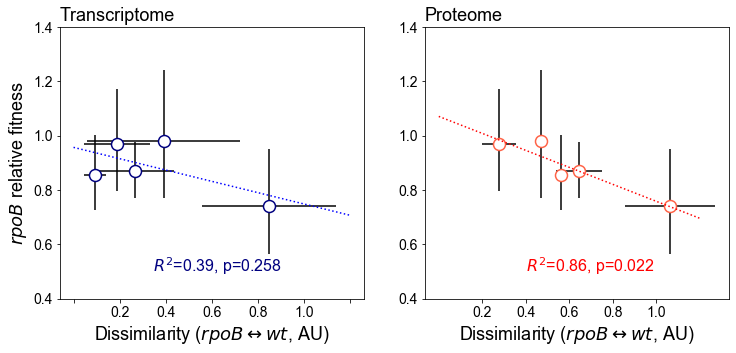

In [34]:
plt.figure('RNA_PROT_DIST', figsize=(12,5))

plt.subplot(121)
plt.title('Transcriptome', size=18, loc='left')
plt.vlines(ALL_df.RNA_EUCLIDEAN, 
           ALL_df.RPOB_HIGH, 
           ALL_df.RPOB_LOW)
plt.hlines(ALL_df.RPOB_COST, 
           ALL_df.RNA_EUCLIDEAN-ALL_df.RNA_EUCLIDEAN_STD, 
           ALL_df.RNA_EUCLIDEAN+ALL_df.RNA_EUCLIDEAN_STD)
plt.plot(ALL_df.RNA_EUCLIDEAN, ALL_df.RPOB_COST, 'o', mfc='white', mec='navy', ms=12, mew=1.5)
s,i,r,p,e = ss.linregress(ALL_df.RNA_EUCLIDEAN, ALL_df.RPOB_COST)
print(ss.spearmanr(ALL_df.RNA_EUCLIDEAN, ALL_df.RPOB_COST))
plt.plot(np.linspace(150000,500000,7), 
         np.linspace(150000,500000,7)*s+i, 'b:')
plt.xticks(np.linspace(150000,500000,7),
           ['',0.2,0.4,0.6,0.8,1.0,''], size=14)
plt.ylim(.4,1.4)
plt.yticks(size=14)
plt.text(0.25e6,.5,r'$R^2$=%.2f, p=%.3f' %(r**2,p), color='navy', size=16)
plt.xlabel(r'Dissimilarity ($rpoB \leftrightarrow wt$, AU)', size=18) #Euclidean distance, $4.5 x 10-5$
plt.ylabel(r'$rpoB$ relative fitness', size=18)

plt.subplot(122)
plt.title('Proteome', size=18, loc='left')
plt.vlines(ALL_df.EUCLIDEAN, 
           ALL_df.RPOB_HIGH, 
           ALL_df.RPOB_LOW)
plt.hlines(ALL_df.RPOB_COST, 
           ALL_df.EUCLIDEAN-ALL_df.EUCLIDEAN_STD, 
           ALL_df.EUCLIDEAN+ALL_df.EUCLIDEAN_STD)
plt.plot(ALL_df.EUCLIDEAN, ALL_df.RPOB_COST, 'o', mfc='white', mec='tomato', ms=12, mew=1.5)
s,i,r,p,e = ss.linregress(ALL_df.EUCLIDEAN, ALL_df.RPOB_COST)
print(ss.spearmanr(ALL_df.EUCLIDEAN, ALL_df.RPOB_COST))
plt.plot(np.linspace(0.0,1.2e7,7), 
         np.linspace(0.0,1.2e7,7)*s+i, 'r:')
plt.xticks([.2e7, .4e7,.6e7,.8e7,1.0e7],
           [0.2, 0.4, 0.6, 0.8, 1.0], size=14)
plt.ylim(.4,1.4)
plt.yticks(size=14)
plt.text(0.4e7,.5,r'$R^2$=%.2f, p=%.3f' %(r**2,p), color='red', size=16)
plt.xlabel(r'Dissimilarity ($rpoB \leftrightarrow wt$, AU)', size=18) #Euclidean distance, $10^{7}$
#plt.ylabel(r'$rpoB$ relative fitness', size=18)

# plt.savefig('./2_RpoB_expression_distance.pdf')
# plt.savefig('./2_RpoB_expression_distance.png', dpi=600)

## Test the underlying mechanism driving this

The impact of these changes could be driven by changes in the ribosomal content, RNA polymerase content or perhaps chaperone levels. We plotted the correlation between growth rate, and relative fitness for the proteomic levels of each one of these groups of proteins.

In [35]:
GC_df = pd.read_csv('../Growth_Curves/GENETIC_DIVERSITY_GROWTH_CURVES.csv') #TbX011 growth curve data

GC_df.head()

,STRAIN,SAMPLE,OD600,TIME,log2OD,BACKGROUND,RESISTANT
0,N1981,N1981_11S,0.22,100.0,-2.184425,N0155,1
1,N1981,N1981_11S,0.36,119.5,-1.473931,N0155,1
2,N1981,N1981_11S,0.42,124.5,-1.251539,N0155,1
3,N1981,N1981_11S,0.67,143.5,-0.577767,N0155,1
4,N1981,N1981_11S,1.08,170.0,0.111031,N0155,1


In [36]:
model = sm.MixedLM.from_formula("log2OD ~ TIME*STRAIN", 
                                data=GC_df, 
                                groups=GC_df.SAMPLE)
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log2OD  
No. Observations:     103        Method:                REML    
No. Groups:           33         Scale:                 0.0095  
Min. group size:      2          Likelihood:            -40.5460
Max. group size:      5          Converged:             Yes     
Mean group size:      3.1                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -6.863    0.542 -12.664 0.000 -7.925 -5.800
STRAIN[T.N0072]      -0.192    0.738  -0.260 0.795 -1.639  1.255
STRAIN[T.N0145]       0.226    0.802   0.281 0.779 -1.347  1.798
STRAIN[T.N0155]       0.394    0.764   0.516 0.606 -1.104  1.892
STRAIN[T.N0157]      -0.431    0.766  -0.563 0.573 -1.933  1.070
STRAIN[T.N1888]      -0.266    0.789  -

Now, let's get the ribosomal genes from KEGG

In [37]:
pathway = 'mtu03010'
pathway_name = 'Ribosome'
pathway_data = rq.get('http://rest.kegg.jp/get/'+pathway)
pathway_genes = []
for line in pathway_data.text.strip().split('\n'):
    split = line.split()
    if 'Rv' in split[0]: 
        pathway_genes.append(split[0])
        
print(pathway_genes)

['Rv2890c', 'Rv0707', 'Rv3458c', 'Rv0721', 'Rv0053', 'Rv0683', 'Rv0718', 'Rv3442c', 'Rv0700', 'Rv3459c', 'Rv0682', 'Rv3460c', 'Rv0717', 'Rv2056c', 'Rv2785c', 'Rv2909c', 'Rv0710', 'Rv2055c', 'Rv0055', 'Rv0705', 'Rv2412', 'Rv0641', 'Rv0704', 'Rv0701', 'Rv0702', 'Rv0716', 'Rv0719', 'Rv0652', 'Rv0056', 'Rv0651', 'Rv0640', 'Rv3443c', 'Rv0714', 'Rv0723', 'Rv0708', 'Rv3456c', 'Rv0720', 'Rv2904c', 'Rv1643', 'Rv2442c', 'Rv0706', 'Rv0703', 'Rv0715', 'Rv1015c', 'Rv2441c', 'Rv2058c', 'Rv0105c', 'Rv2975a', 'Rv0709', 'Rv0722', 'Rv1298', 'Rv0979A', 'Rv2057c', 'Rv0634B', 'Rv3924c', 'Rv1642', 'Rv3461c', 'Rvnr01', 'Rvnr02', 'Rvnr03']


Let's add up their LFQs.

In [38]:
proteome[proteome.index.isin(pathway_genes)].sum(axis=0)[:24]

L2_11S    2.580405e+07
L2_12S    2.633865e+07
L1_11S    2.827432e+07
L1_12S    2.705805e+07
L1_13S    2.673605e+07
L2_21S    2.698309e+07
L2_22S    2.704886e+07
L2_31S    2.717949e+07
L2_32S    2.736051e+07
L1_21S    2.676397e+07
L1_22S    2.848365e+07
L1_23S    2.519611e+07
L2_21R    2.707581e+07
L2_22R    2.766498e+07
L2_31R    2.738944e+07
L2_32R    2.758258e+07
L1_11R    2.886621e+07
L1_12R    2.766236e+07
L1_13R    2.818842e+07
L1_21R    2.575815e+07
L1_22R    2.840862e+07
L1_23R    2.834408e+07
L2_11R    2.644238e+07
L2_12R    2.583782e+07
dtype: float64

Let's see what proportion of the overall aLFQs that is

In [39]:
ribosomal_levels = proteome[proteome.index.isin(pathway_genes)].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]
proteome[proteome.index.isin(pathway_genes)].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]

L2_11S    0.051791
L2_12S    0.052863
L1_11S    0.056749
L1_12S    0.054306
L1_13S    0.053660
L2_21S    0.054156
L2_22S    0.054287
L2_31S    0.054549
L2_32S    0.054913
L1_21S    0.053716
L1_22S    0.057167
L1_23S    0.050571
L2_21R    0.054341
L2_22R    0.055523
L2_31R    0.054972
L2_32R    0.055358
L1_11R    0.057937
L1_12R    0.055523
L1_13R    0.056577
L1_21R    0.051699
L1_22R    0.057021
L1_23R    0.056891
L2_11R    0.053073
L2_12R    0.051860
dtype: float64

About 5% on average - that's lower than reports in the literature [Schubert *et al.*, Cell Host Microbe 2015]. Does it matter if we have rpoB mutation?

MannwhitneyuResult(statistic=46.0, pvalue=0.07047760957218573)

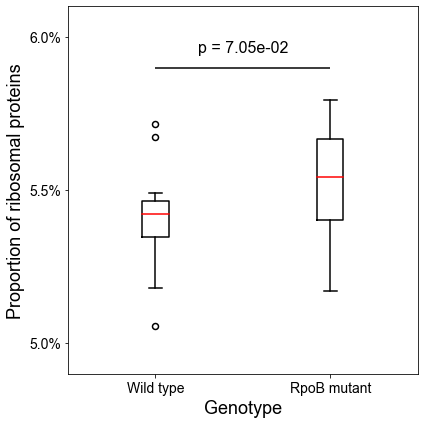

In [40]:
plt.figure(figsize=(6,6))
plt.boxplot([ribosomal_levels[:12],ribosomal_levels[12:]],
            boxprops={'linewidth':1.5}, whiskerprops={'linewidth':1.5},
            capprops={'linewidth':1.5},medianprops={'linewidth':1.5, 'color':'red'}, 
            flierprops={'mew':1.5})
plt.xticks([1,2],['Wild type','RpoB mutant'], size=14)
plt.xlabel('Genotype', size=18)
#plt.title('ATP equivalents', size=18)
plt.ylim(0.049,0.061)
plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
plt.ylabel('Proportion of ribosomal proteins', size=18)
plt.hlines(0.059,1,2)
plt.text(1.5,
         0.0595,
         'p = {0:0=.2e}'.format(ss.mannwhitneyu(ribosomal_levels[:12],ribosomal_levels[12:])[1]), 
         horizontalalignment='center',
         size=16)

plt.tight_layout()

ss.mannwhitneyu(ribosomal_levels[:12],ribosomal_levels[12:])

So it seems that rpoB mutants actually have higher levels of ribosomes...

Let's see how this correlates with growth rate in general.

In [41]:
strains = ['N0052','N0072','N0145','N0155','N0157','N1888','N1981','N2027','N2030','N2495']
growth_rates = [1/result.params['TIME']] 
#for x in strains[1:]:
#    growth_rates.append(result.params['TIME:STRAIN[T.{}]'.format])
growth_rates += [1/(result.params['TIME']+result.params['TIME:STRAIN[T.{}]'.format(x)]) for x in strains[1:]]

In [42]:
mean_ribosomal_levels = []
for reps in [[0,1],[2,3,4],[5,6],[7,8],[9,10,11],
             [12,13],[14,15],[16,17,18],[19,20,21],[22,23]]:
    mean_ribosomal_levels.append(np.mean(ribosomal_levels[reps]))

In [43]:
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_ribosomal_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_ribosomal_levels)
#s,i,r,p,e = ss.linregress(np.array(growth_rates)**-1,mean_ribosomal_levels)
print(s,r**2,p)
print(rho,prho)

0.0002339849204761406 0.2950255496758265 0.10467964578046811
0.6121212121212121 0.05997214247725524


Text(21, 0.059, 'R2 = 0.30, p = 0.10\nrho = 0.61, p = 0.06')

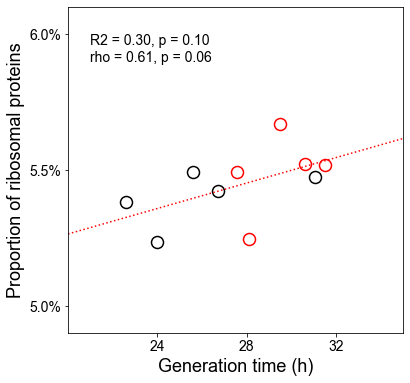

In [44]:
plt.figure(figsize=(6,6))
plt.plot(np.array(growth_rates)[:5],mean_ribosomal_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12)
plt.plot(np.array(growth_rates)[5:],mean_ribosomal_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:')
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
#plt.plot(np.array(growth_rates)**-1,mean_ribosomal_levels,'o',mew=1.5,mec='black',mfc='none')
#plt.plot(np.arange(0,0.1,.05), np.arange(0,.1,.05)*s+i, 'r:')
#plt.xlim(0.030,0.045)
#plt.xticks(np.arange(0.03,0.046,0.005),size=14)
plt.xlabel('Generation time (h)', size=18)
plt.ylim(0.049,0.061)
plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
plt.ylabel('Proportion of ribosomal proteins', size=18)
plt.text(21,0.059,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)

# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.pdf')
# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.png', dpi=600)

Overall, the ribosomal proportion seems to be relatively stable at around 5.5%. Contrary to what I would expect, there is a positive correlation between generation time and ribosomal proportion... Which would suggest that the more ribosomes there are the slower *Mtb* grows.

Let's put these two together.

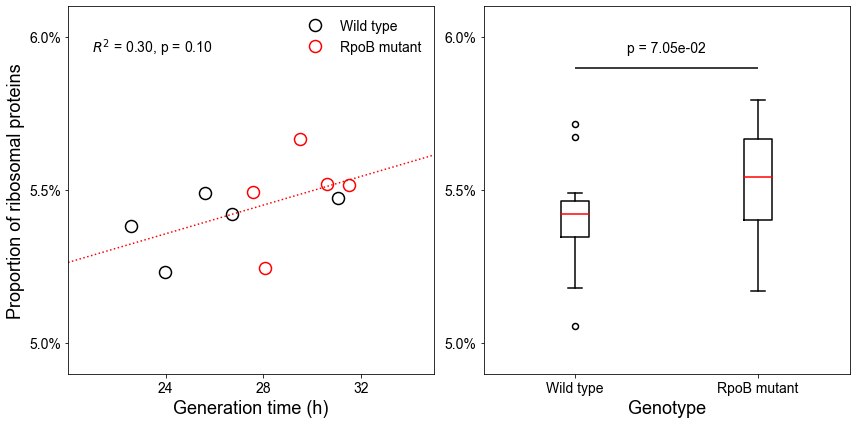

In [45]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.array(growth_rates)[:5],mean_ribosomal_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12, label = 'Wild type')
plt.plot(np.array(growth_rates)[5:],mean_ribosomal_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12, label='RpoB mutant')
plt.legend(frameon=False, fontsize=14)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:')
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
#plt.plot(np.array(growth_rates)**-1,mean_ribosomal_levels,'o',mew=1.5,mec='black',mfc='none')
#plt.plot(np.arange(0,0.1,.05), np.arange(0,.1,.05)*s+i, 'r:')
#plt.xlim(0.030,0.045)
#plt.xticks(np.arange(0.03,0.046,0.005),size=14)
plt.xlabel('Generation time (h)', size=18)
plt.ylim(0.049,0.061)
plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
plt.ylabel('Proportion of ribosomal proteins', size=18)
#plt.text(21,0.0595,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)
plt.text(21,0.0595,r'$R^2$ = {0:0=.2f}, p = {1:1=.2f}'.format(r**2,p,), size=14)

plt.subplot(122)
plt.boxplot([ribosomal_levels[:12],ribosomal_levels[12:]],
            boxprops={'linewidth':1.5}, whiskerprops={'linewidth':1.5},
            capprops={'linewidth':1.5},medianprops={'linewidth':1.5, 'color':'red'}, 
            flierprops={'mew':1.5})
plt.xticks([1,2],['Wild type','RpoB mutant'], size=14)
plt.xlabel('Genotype', size=18)
#plt.title('ATP equivalents', size=18)
plt.ylim(0.049,0.061)
plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
plt.hlines(0.059,1,2)
plt.text(1.5,
         0.0595,
         'p = {0:0=.2e}'.format(ss.mannwhitneyu(ribosomal_levels[:12],ribosomal_levels[12:])[1]), 
         horizontalalignment='center',
         size=14)

plt.tight_layout()

# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.pdf')
# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.png', dpi=600)

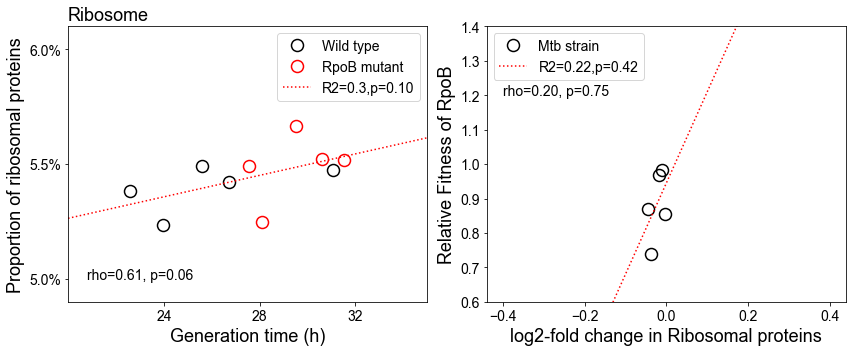

In [76]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.array(growth_rates)[:5],mean_ribosomal_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12, label = 'Wild type')
plt.plot(np.array(growth_rates)[5:],mean_ribosomal_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12, label='RpoB mutant')
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_ribosomal_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_ribosomal_levels)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')

plt.text(20.8,0.05,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.legend(frameon=True, fontsize=14)
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
plt.xlabel('Generation time (h)', size=18)

plt.ylim(0.049,0.061)
plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
plt.ylabel('Proportion of ribosomal proteins',size=18)
plt.title('Ribosome',size=18,loc='left')

plt.subplot(122)
plt.plot(np.log2(np.array(mean_ribosomal_levels)[:5]/np.array(mean_ribosomal_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],
         'o',  mew=1.5,mec='black',mfc='none',ms=12, label = 'Mtb strain')
s,i,r,p,e = ss.linregress(np.log2(np.array(mean_ribosomal_levels)[:5]/np.array(mean_ribosomal_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],)
rho,prho = ss.spearmanr(np.array(mean_ribosomal_levels)[:5]/np.array(mean_ribosomal_levels)[[9,7,5,6,8]],ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])])

plt.plot([-0.4,.4],np.array([-0.4,.4])*s+i,'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')
plt.legend(fontsize=14)

plt.text(-0.4,1.2,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.ylim(0.6,1.4)
plt.yticks(size=14)
plt.ylabel(r'Relative Fitness of RpoB', size=18)
plt.xticks(np.arange(-0.4,0.41,.2),size=14)
plt.xlabel('log2-fold change in Ribosomal proteins', size=18)
# plt.ylim(0.8,1.4)
# plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
# plt.ylabel('Proportion of ribosomal proteins', size=18)
# #plt.text(21,0.0595,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)
# plt.text(21,0.0595,r'$R^2$ = {0:0=.2f}, p = {1:1=.2f}'.format(r**2,p,), size=14)


plt.tight_layout()

# plt.savefig('./1_Ribosome_normed_fitness_correlation.pdf')

## RNAP?
RNAP levels were found to be relevant in Gram-negative compensation.

In [48]:
RNAP_genes = [
    'Rv0667', 'Rv0668','Rv1390','Rv3457c'
]
RNAP_levels = proteome[proteome.index.isin(RNAP_genes)].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]
proteome[proteome.index.isin(RNAP_genes)].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]

L2_11S    0.009482
L2_12S    0.009762
L1_11S    0.010894
L1_12S    0.011012
L1_13S    0.010611
L2_21S    0.009953
L2_22S    0.010107
L2_31S    0.010371
L2_32S    0.010300
L1_21S    0.010339
L1_22S    0.010320
L1_23S    0.009233
L2_21R    0.011383
L2_22R    0.011681
L2_31R    0.010332
L2_32R    0.010050
L1_11R    0.011215
L1_12R    0.010717
L1_13R    0.011104
L1_21R    0.010485
L1_22R    0.010517
L1_23R    0.010846
L2_11R    0.010187
L2_12R    0.010332
dtype: float64

In [49]:
mean_RNAP_levels = []
for reps in [[0,1],[2,3,4],[5,6],[7,8],[9,10,11],
             [12,13],[14,15],[16,17,18],[19,20,21],[22,23]]:
    mean_RNAP_levels.append(np.mean(RNAP_levels[reps]))

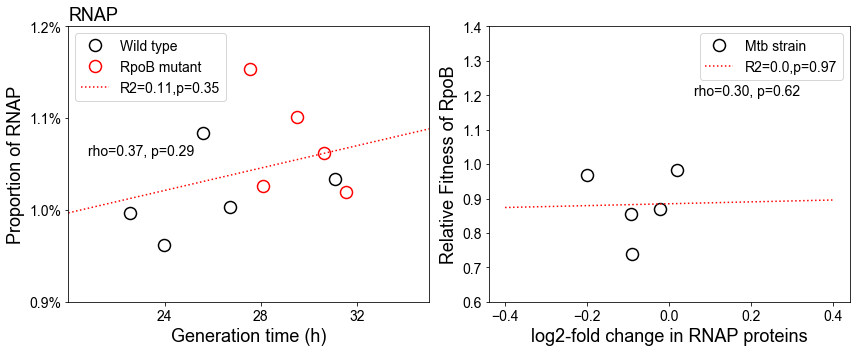

In [73]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.array(growth_rates)[:5],mean_RNAP_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12, label = 'Wild type')
plt.plot(np.array(growth_rates)[5:],mean_RNAP_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12, label='RpoB mutant')
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_RNAP_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_RNAP_levels)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')

plt.text(20.8,0.0106,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.legend(frameon=True, fontsize=14)
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
plt.xlabel('Generation time (h)', size=18)

plt.ylim(0.009,0.012)
plt.yticks([0.009, 0.01,0.011,0.012], ['0.9%', '1.0%', '1.1%', '1.2%'], size=14)
plt.ylabel('Proportion of RNAP',size=18)
plt.title('RNAP',size=18,loc='left')

plt.subplot(122)
plt.plot(np.log2(np.array(mean_RNAP_levels)[:5]/np.array(mean_RNAP_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],
         'o',  mew=1.5,mec='black',mfc='none',ms=12, label = 'Mtb strain')
s,i,r,p,e = ss.linregress(np.log2(np.array(mean_RNAP_levels)[:5]/np.array(mean_RNAP_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],)
rho,prho = ss.spearmanr(np.array(mean_RNAP_levels)[:5]/np.array(mean_RNAP_levels)[[9,7,5,6,8]],ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])])

plt.plot([-0.4,.4],np.array([-0.4,.4])*s+i,'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')
plt.legend(fontsize=14)

plt.text(0.06,1.2,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.ylim(0.6,1.4)
plt.yticks(size=14)
plt.ylabel(r'Relative Fitness of RpoB', size=18)
plt.xticks(np.arange(-0.4,0.41,.2),size=14)
plt.xlabel('log2-fold change in RNAP proteins', size=18)
# plt.ylim(0.8,1.4)
# plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
# plt.ylabel('Proportion of ribosomal proteins', size=18)
# #plt.text(21,0.0595,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)
# plt.text(21,0.0595,r'$R^2$ = {0:0=.2f}, p = {1:1=.2f}'.format(r**2,p,), size=14)


plt.tight_layout()

# plt.savefig('./1_RNAP_fitness_correlation.pdf')

## DnaJ2? 
Following the reviewer comments, let's have a look at whether DnaJ2 levels impact cost.

In [61]:
dnaJ2_levels = proteome[proteome.index.isin(['Rv2373c'])].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]
proteome[proteome.index.isin(['Rv2373c'])].sum(axis=0)[:24]/proteome.sum(axis=0)[:24]

L2_11S    0.000450
L2_12S    0.000463
L1_11S    0.000506
L1_12S    0.000483
L1_13S    0.000480
L2_21S    0.000497
L2_22S    0.000515
L2_31S    0.000480
L2_32S    0.000504
L1_21S    0.000452
L1_22S    0.000467
L1_23S    0.000404
L2_21R    0.000524
L2_22R    0.000513
L2_31R    0.000544
L2_32R    0.000566
L1_11R    0.000382
L1_12R    0.000378
L1_13R    0.000399
L1_21R    0.000339
L1_22R    0.000418
L1_23R    0.000362
L2_11R    0.000475
L2_12R    0.000454
dtype: float64

In [62]:
mean_dnaJ2_levels = []
for reps in [[0,1],[2,3,4],[5,6],[7,8],[9,10,11],
             [12,13],[14,15],[16,17,18],[19,20,21],[22,23]]:
    mean_dnaJ2_levels.append(np.mean(dnaJ2_levels[reps]))

In [63]:
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_dnaJ2_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_dnaJ2_levels)
#s,i,r,p,e = ss.linregress(np.array(growth_rates)**-1,mean_ribosomal_levels)
print(s,r**2,p)
print(rho,prho)

9.551323446297215e-07 0.0025977244877045955 0.8887969439800159
0.22424242424242422 0.5334005612725947


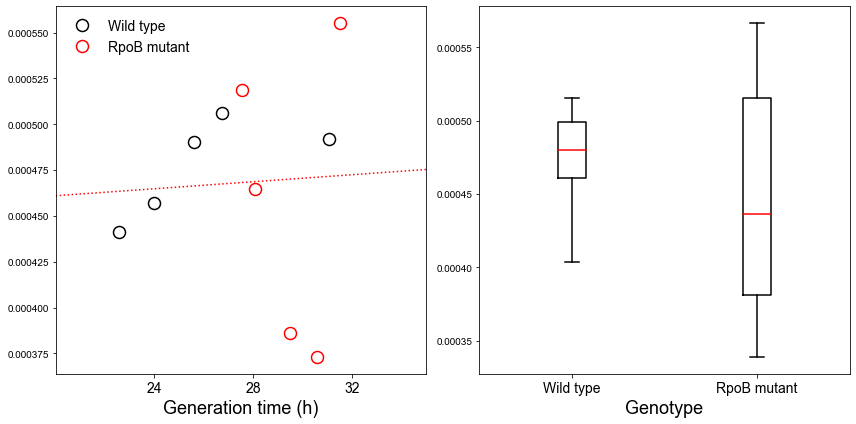

In [64]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.array(growth_rates)[:5],mean_dnaJ2_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12, label = 'Wild type')
plt.plot(np.array(growth_rates)[5:],mean_dnaJ2_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12, label='RpoB mutant')
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_dnaJ2_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_dnaJ2_levels)
plt.legend(frameon=False, fontsize=14)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:')
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
#plt.plot(np.array(growth_rates)**-1,mean_ribosomal_levels,'o',mew=1.5,mec='black',mfc='none')
#plt.plot(np.arange(0,0.1,.05), np.arange(0,.1,.05)*s+i, 'r:')
#plt.xlim(0.030,0.045)
#plt.xticks(np.arange(0.03,0.046,0.005),size=14)
plt.xlabel('Generation time (h)', size=18)
# plt.ylim(0.049,0.061)
# plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
# plt.ylabel('Proportion of ribosomal proteins', size=18)
# #plt.text(21,0.0595,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)
# plt.text(21,0.0595,r'$R^2$ = {0:0=.2f}, p = {1:1=.2f}'.format(r**2,p,), size=14)

plt.subplot(122)
plt.boxplot([dnaJ2_levels[:12],dnaJ2_levels[12:]],
            boxprops={'linewidth':1.5}, whiskerprops={'linewidth':1.5},
            capprops={'linewidth':1.5},medianprops={'linewidth':1.5, 'color':'red'}, 
            flierprops={'mew':1.5})
plt.xticks([1,2],['Wild type','RpoB mutant'], size=14)
plt.xlabel('Genotype', size=18)
#plt.title('ATP equivalents', size=18)
# plt.ylim(0.049,0.061)
# plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
# plt.hlines(0.059,1,2)
# plt.text(1.5,
#          0.0595,
#          'p = {0:0=.2e}'.format(ss.mannwhitneyu(dnaJ2_levels[:12],dnaJ2_levels[12:])[1]), 
#          horizontalalignment='center',
#          size=14)

plt.tight_layout()

# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.pdf')
# plt.savefig('../cost-of-resistance/reports/figures/2_Ribosomal_protein_growth.png', dpi=600)

Doesn't seem like there is anything systematic. Let's plot this as relative fitness vs relative abundance delta.

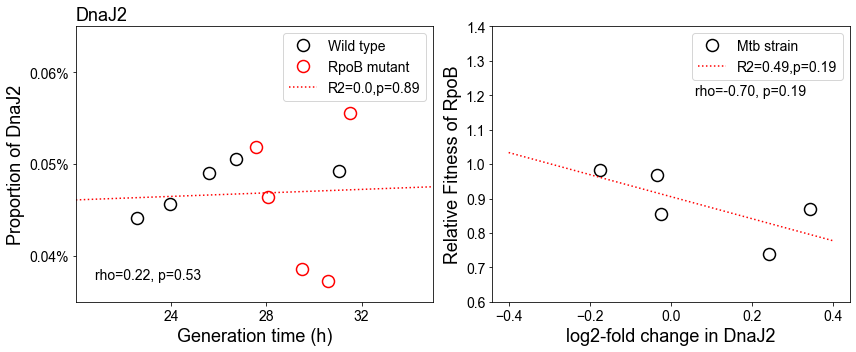

In [74]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(np.array(growth_rates)[:5],mean_dnaJ2_levels[:5],'o',
         mew=1.5,mec='black',mfc='none',ms=12, label = 'Wild type')
plt.plot(np.array(growth_rates)[5:],mean_dnaJ2_levels[5:],'o',
         mew=1.5,mec='red',mfc='none',ms=12, label='RpoB mutant')
s,i,r,p,e = ss.linregress(np.array(growth_rates),mean_dnaJ2_levels)
rho,prho = ss.spearmanr(np.array(growth_rates),mean_dnaJ2_levels)
plt.plot(np.arange(20,41,5), np.arange(20,41,5)*s+i, 'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')

plt.text(20.8,0.000375,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.legend(frameon=True, fontsize=14)
plt.xlim(20,35)
plt.xticks(np.arange(24,36,4),size=14)
plt.xlabel('Generation time (h)', size=18)

plt.ylim(0.00035,0.00065)
plt.yticks([0.0004, 0.0005,0.0006], ['0.04%', '0.05%', '0.06%'], size=14)
plt.ylabel('Proportion of DnaJ2',size=18)
plt.title('DnaJ2',size=18,loc='left')

plt.subplot(122)
plt.plot(np.log2(np.array(mean_dnaJ2_levels)[:5]/np.array(mean_dnaJ2_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],
         'o',  mew=1.5,mec='black',mfc='none',ms=12, label = 'Mtb strain')
s,i,r,p,e = ss.linregress(np.log2(np.array(mean_dnaJ2_levels)[:5]/np.array(mean_dnaJ2_levels)[[9,7,5,6,8]]),ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])],)
rho,prho = ss.spearmanr(np.array(mean_dnaJ2_levels)[:5]/np.array(mean_dnaJ2_levels)[[9,7,5,6,8]],ALL_df.RPOB_COST[ALL_df.index.isin(['N0052','N0072','N0145','N0155','N0157'])])

plt.plot([-0.4,.4],np.array([-0.4,.4])*s+i,'r:',label=f'R2={np.round(r**2,2)},p={p:.2f}')
plt.legend(fontsize=14)

plt.text(0.06,1.2,f'rho={rho:.2f}, p={prho:.2f}', size=14)

plt.ylim(0.6,1.4)
plt.yticks(size=14)
plt.ylabel(r'Relative Fitness of RpoB', size=18)
plt.xticks(np.arange(-0.4,0.41,.2),size=14)
plt.xlabel('log2-fold change in DnaJ2', size=18)
# plt.ylim(0.8,1.4)
# plt.yticks([0.05, 0.055,0.060], ['5.0%', '5.5%', '6.0%'], size=14)
# plt.ylabel('Proportion of ribosomal proteins', size=18)
# #plt.text(21,0.0595,'R2 = {0:0=.2f}, p = {1:1=.2f}\nrho = {2:2=.2f}, p = {3:3=.2f}'.format(r**2,p,rho,prho), size=14)
# plt.text(21,0.0595,r'$R^2$ = {0:0=.2f}, p = {1:1=.2f}'.format(r**2,p,), size=14)


plt.tight_layout()

plt.savefig('./1_DNAJ2_fitness_correlation.pdf')
# plt.savefig('./../cost-of-resistance/reports/figures/1_DNAJ2_fitness_correlation.png',dpi=600)